In [1]:
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import json
from scipy.stats import entropy
from sklearn.neighbors import KernelDensity

In [2]:
runs = [
    "rl-run-data.json",
    "rl-run-dqn-1-data.json",
    "rl-run-dqn-7-data.json"
]

data = defaultdict(list)
for run in runs:
    with open(run, "r") as f:
        data_new = json.load(f)
        for map_name in data_new:
            data[map_name] = data[map_name]+data_new[map_name]

In [3]:
max_epsilon = 0
min_epsilon = np.inf
map_name = list(data.keys())[0]
for i in range(len(data[map_name])):
        epsilon = data[map_name][i]["info"]["epsilon"]
        max_epsilon = max(max_epsilon, epsilon)
        min_epsilon = min(min_epsilon, epsilon)

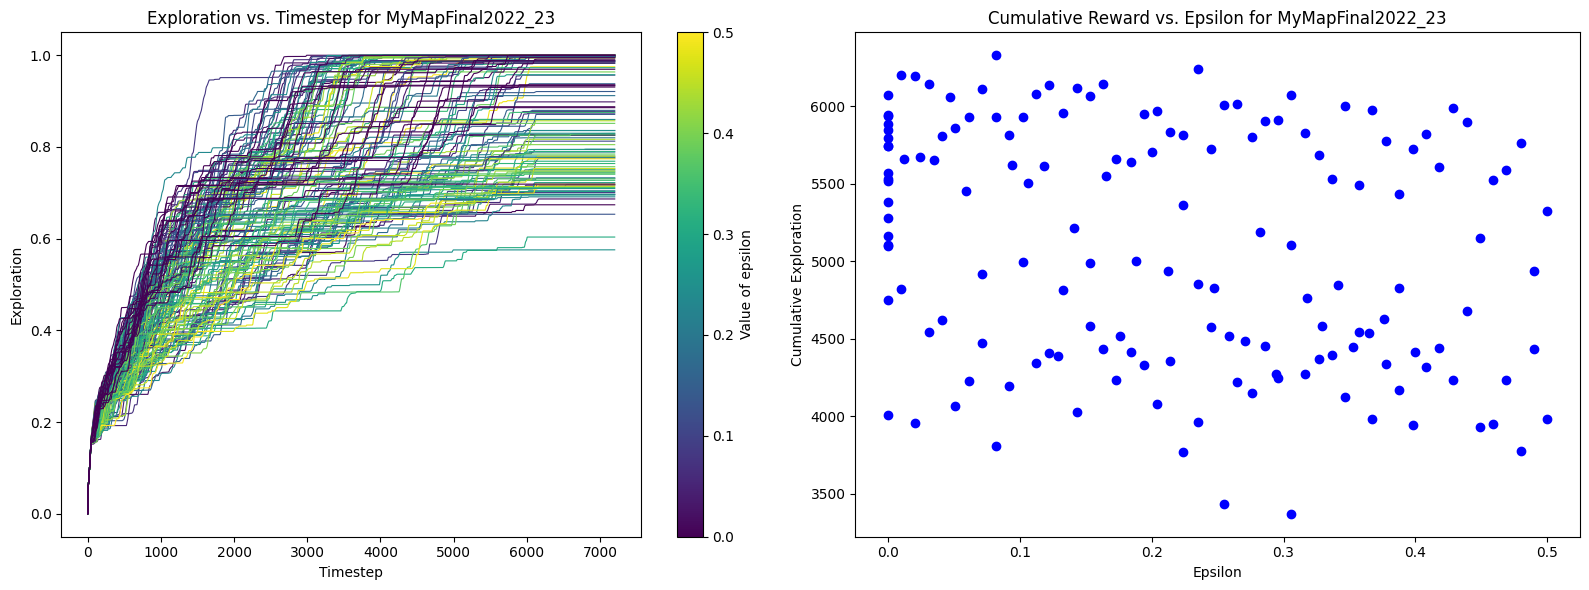

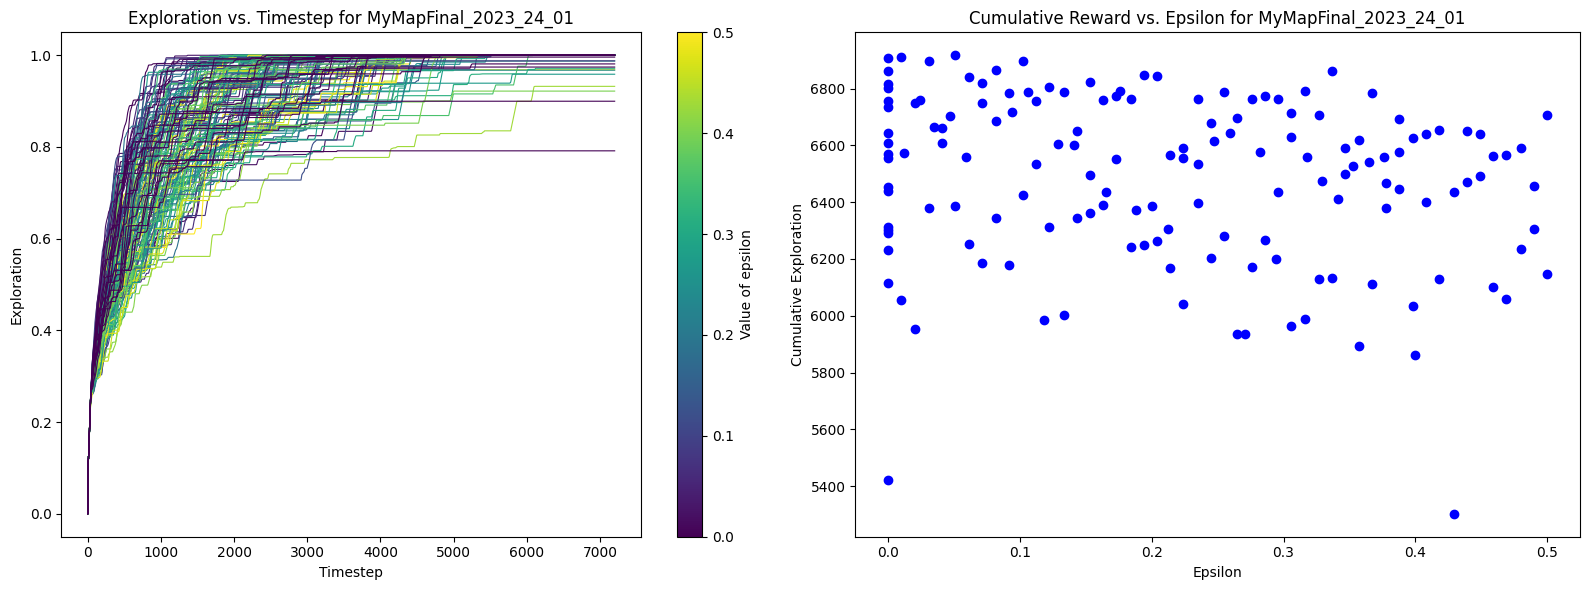

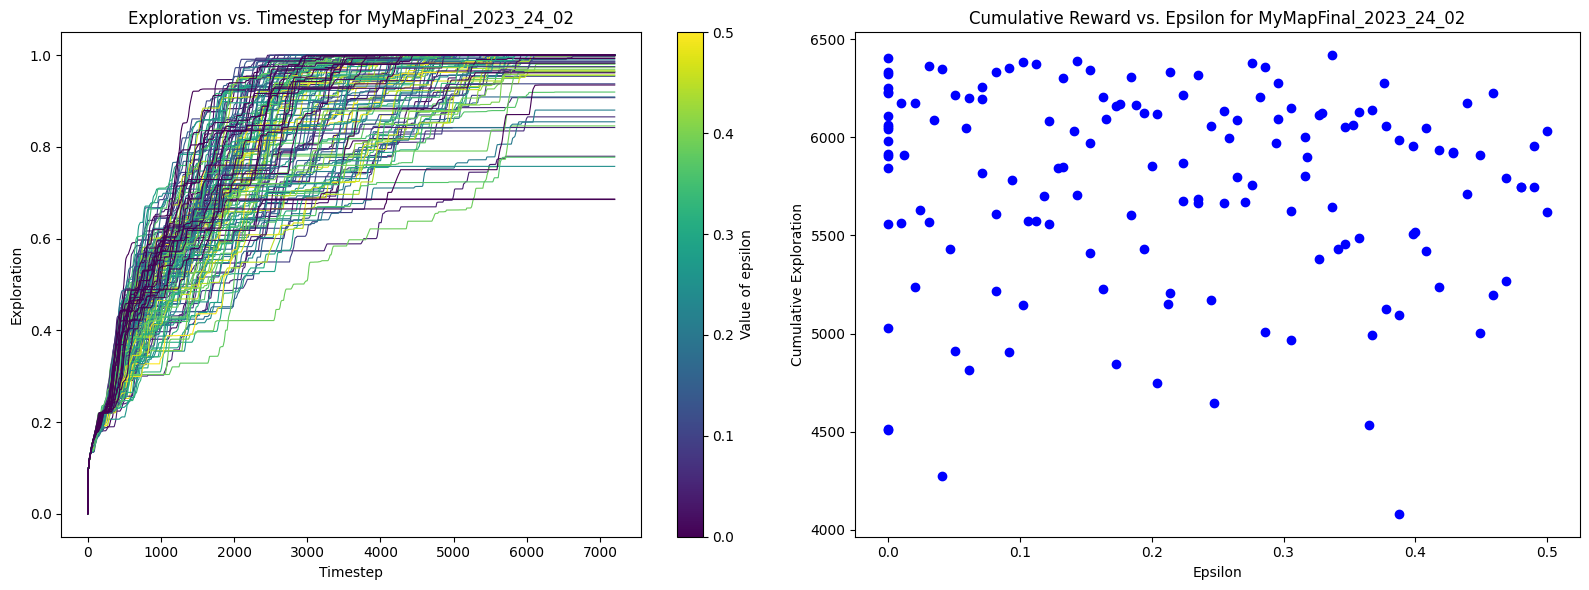

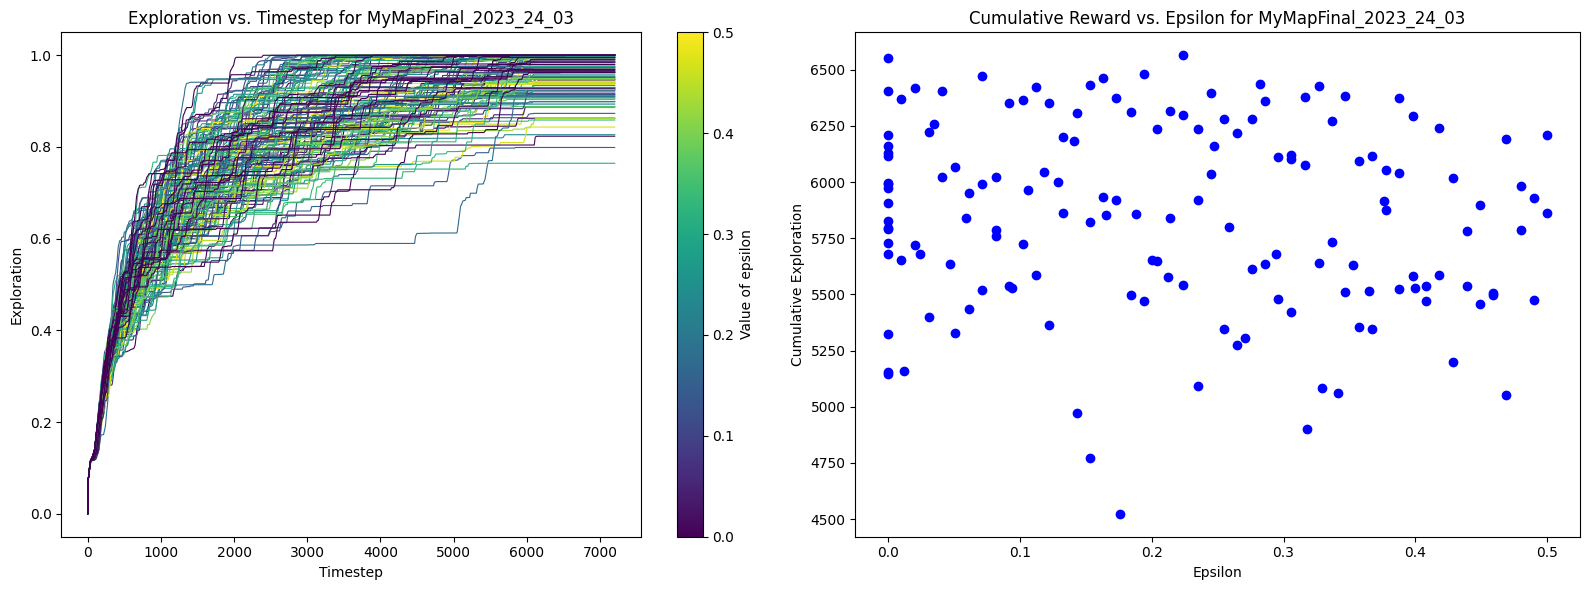

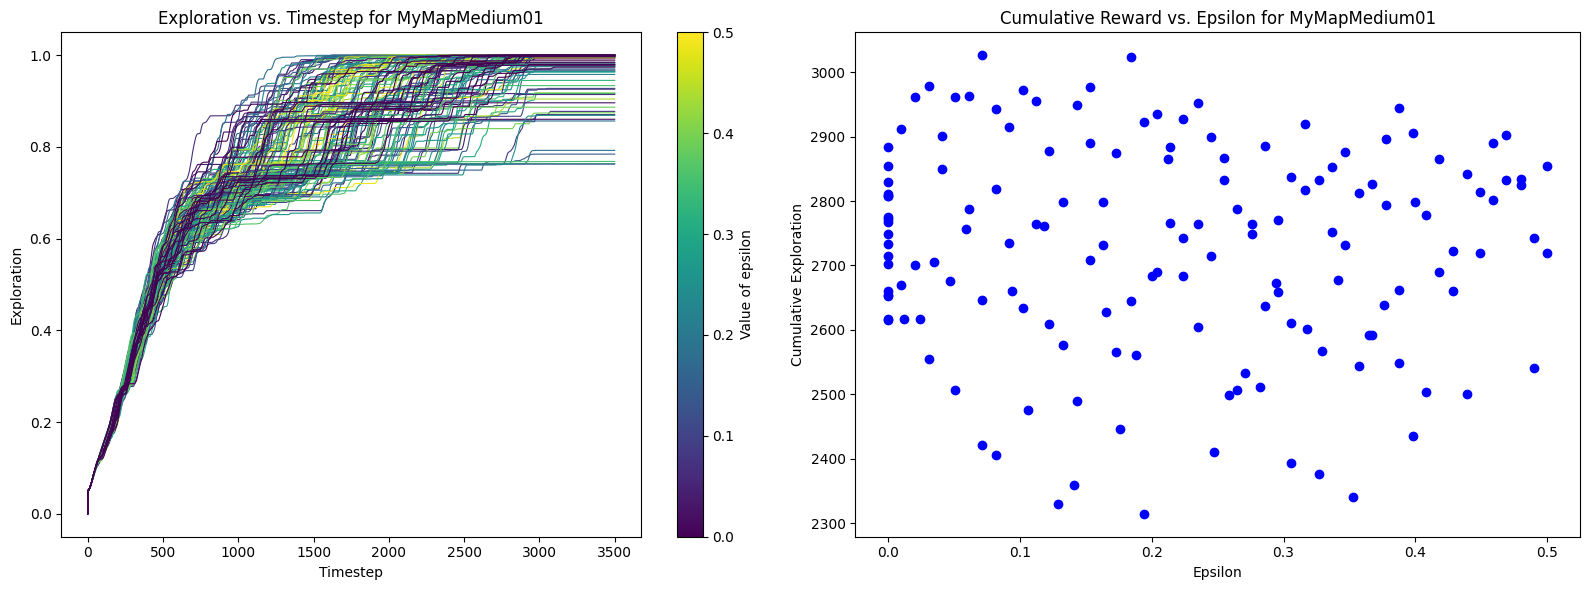

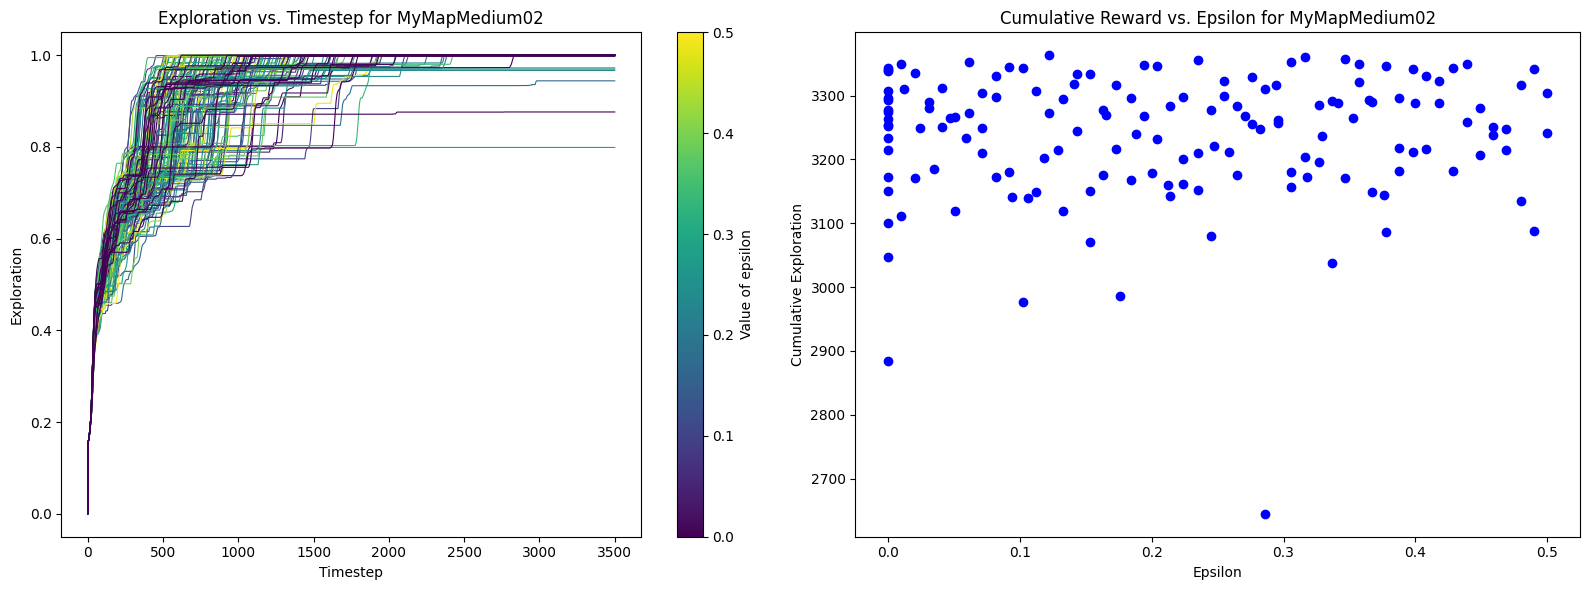

In [4]:
norm = plt.Normalize(min_epsilon, max_epsilon)
cm = plt.cm.viridis

for map_name in data:
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot the exploration in respect to timestep (Left plot)
    ax1.set_title(f"Exploration vs. Timestep for {map_name}")
    for i in range(len(data[map_name])):
        ax1.plot(
            data[map_name][i]["score"], 
            color=cm(norm(data[map_name][i]["info"]["epsilon"])), 
            linewidth=0.8
        )
    sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
    sm.set_array([])  # Required for ScalarMappable
    fig.colorbar(sm, label="Value of epsilon", ax=ax1)
    ax1.set_xlabel("Timestep")
    ax1.set_ylabel("Exploration")
    
    # Plot the cumulative reward as a function of epsilon (Right plot)
    ax2.set_title(f"Cumulative Reward vs. Epsilon for {map_name}")
    cumulative_rewards = [sum(data[map_name][i]["score"]) for i in range(len(data[map_name]))]
    epsilons = [data[map_name][i]["info"]["epsilon"] for i in range(len(data[map_name]))]
    ax2.plot(epsilons, cumulative_rewards, marker="o", linestyle="None", color="blue", linewidth=1.5)
    ax2.set_xlabel("Epsilon")
    ax2.set_ylabel("Cumulative Exploration")
    
    # Adjust layout and show
    plt.tight_layout()
    plt.show()

In [18]:
def get_rewards():
    rewards = defaultdict(list)
    for map_name in data:
        for i in range(len(data[map_name])):
            rewards[map_name].append(np.sum(data[map_name][i]["score"]))
    return rewards

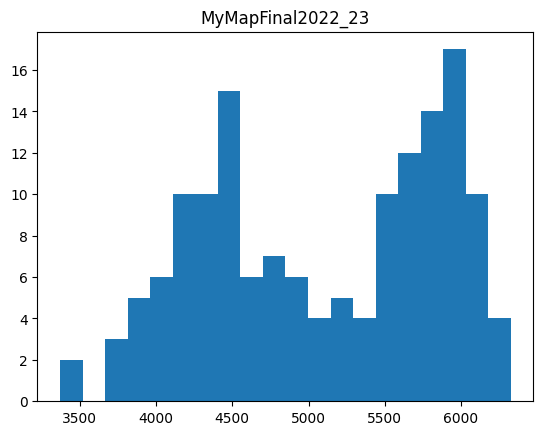

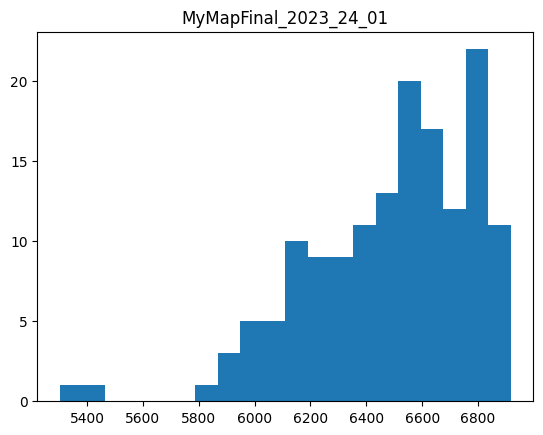

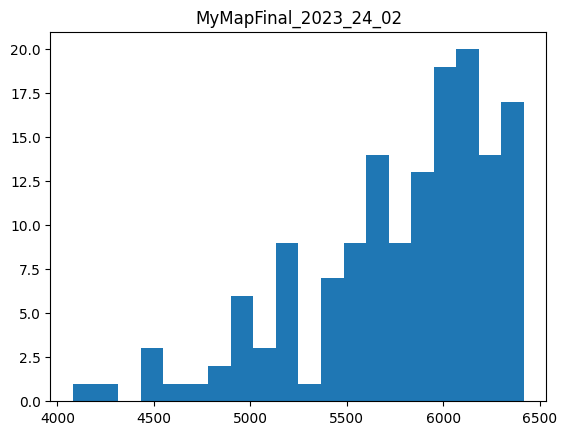

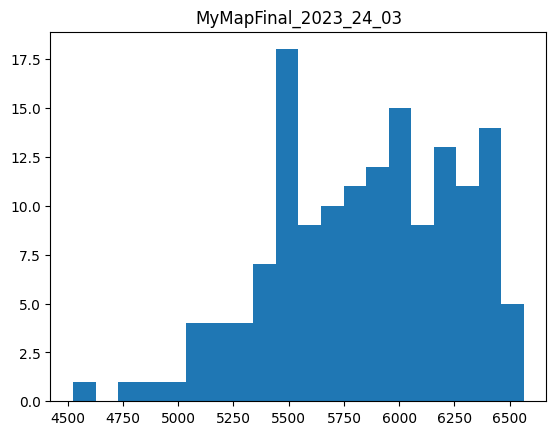

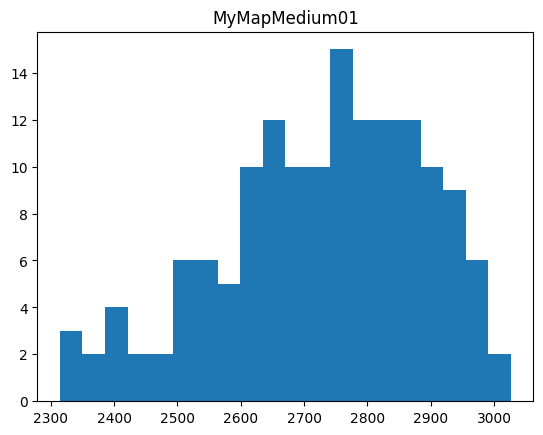

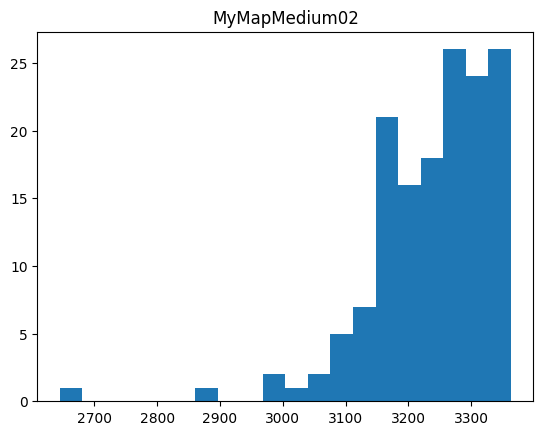

In [19]:
rewards = get_rewards()
for map_name in rewards:
    plt.figure()
    plt.title(map_name)
    plt.hist(rewards[map_name],bins=20)

plt.show()

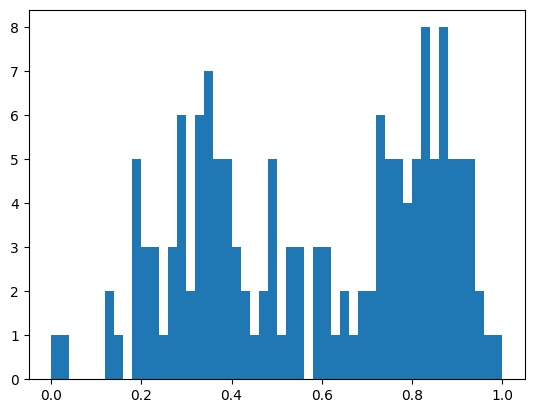

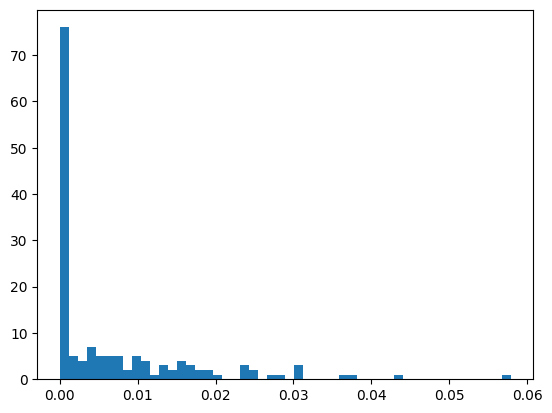

In [28]:
from scipy.special import softmax


weights = np.array(rewards["MyMapFinal2022_23"])
weights = (weights-np.min(weights))/(np.max(weights)-np.min(weights))
plt.hist(weights,bins=50)
plt.figure()
weights = softmax(weights * 2)
plt.hist(weights,bins=50)
plt.show()